# Set-up

## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.cm import plasma
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm

from scipy.stats import pearsonr, spearmanr

from utils import functional_norm, normalize_curves, month_to_season
from decompose_load import non_blind_separation, decompose_load, decompose_daily_consumption, get_monthly_sectors_consumption
from blind_separation import get_D, get_indicators, get_Y, get_curves_info, process_sector_consumption

colors = sns.color_palette("deep")
sns.set_theme()
pd.options.mode.chained_assignment = None

## Parameters

In [2]:
# arrays_path = f'data/3_output/nmf_results/batch_clean/clean_results_{n_comp}comp_{n_runs}runs.npz'
train_load_path = 'data/daily_curves_2020_to_2022.csv'
test_load_path = 'data/daily_curves_2023.csv'
train_results_path = "data/lcnmf_ens_opt_2020_to_2022.npz"
models_path = train_results_path.replace('.npz', '.pkl')

imser_file = 'data/1_input/indicators/IMSER2.xlsx'
imcei_file = 'data/1_input/indicators/IMCEI_mensile.xlsx'
enel_files = [
    'data/1_input/indicators/Domestico 2020 e 2021.xlsx', 
    'data/1_input/indicators/Domestico 2022 e 2023.xlsx'
]
consumption_file = 'data/1_input/consumption/consumption.xlsx'

hue_order = {
    'daytype': ['Monday', 'Working day', 'Saturday', 'Holiday'],
    'season': ['Spring', 'Summer', 'Fall', 'Winter']
}

sectors = ['Domestic', 'Industry', 'Services']

indicator = {
    'Domestic': 'Enel',
    'Industry': 'IMCEI',
    'Services': 'IMSER',
}

## Functions

In [3]:
def plot_monthly_cons(Y_pred, Y, sector, train_months, test_months, linewidth=3, figsize=(15, 6), ylim=(0, 16000), fontsize=18, legend_loc='upper left'):
    fig, ax = plt.subplots(figsize=figsize)

    sns.lineplot(
        data=Y_pred[Y_pred.index.isin(test_months)].reset_index(),
        x='date',
        y=sector,
        color=colors[3],
        label='Predicted',
        errorbar='pi',
        ax=ax,
        # marker='o',
        linewidth=linewidth
    )

    sns.lineplot(
        data=Y_pred[Y_pred.index.isin(train_months)].reset_index(),
        x='date',
        y=sector,
        color='grey',
        label='Fitted',
        errorbar='pi',
        ax=ax,
        # marker='o',
        linewidth=linewidth
    )

    # HOTFIX specific for year 2023
    Y.loc[Y.index.year < 2023, sector].plot(color=colors[0], label='Target', ax=ax, linewidth=linewidth)
    Y.loc[Y.index.year == 2023, sector].plot(color='lightblue', label='Target estimate', ax=ax, linewidth=linewidth)

    ax.set_ylim(ylim)
    ax.set_ylabel('Consumption [GWh]')
    ax.set_xlabel(None, fontsize=fontsize)
    ax.set_ylabel("Consumption [GWh]", fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=fontsize-2, loc=legend_loc)

    plt.show()

def plot_correlation_yoy(yoy_true, yoy_pred, correlation='Pearson'):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    for i, sector in enumerate(sectors):

        x = yoy_true.loc[:, indicator[sector]]
        y = yoy_pred.loc[:, sector]

        # Calculate correlation and p-value
        if correlation == 'Spearman':
            corr, p_value = spearmanr(x, y)
        else:
            corr, p_value = pearsonr(x, y)

        sns.scatterplot(x=x, y=y, ax=axs[i])

        axs[i].plot([x.min(), x.max()], [x.min(), x.max()], color='grey', linestyle='--', linewidth=1, label="y = x")

        # Display correlation and p-value on the plot
        axs[i].text(0.05, 0.95, f'{correlation} r = {corr:.2f}\np-value = {p_value:.3f}', 
                    fontsize=12, ha='left', va='top', transform=axs[i].transAxes)

        # Customize the plot
        # axs[i].set_title(f"Scatter Plot with Pearson Correlation for {year}")
        axs[i].set_xlabel(f"{indicator[sector]} YoY%")
        axs[i].set_ylabel(f"BSS {sector} YoY%")

    # Set a common title for all subplots
    fig.suptitle(f"{correlation} correlation", fontsize=16)

    # Adjust the layout
    plt.subplots_adjust(wspace=0.3, hspace=0.2)


def plot_profiles(profiles_ens, sector, hue, palette=None, figsize=(10, 6), fontsize=18):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(
        data=profiles_ens.groupby([hue, 'hour', 'model'], as_index=False)[sector].mean(),
        x='hour',
        y=sector,
        errorbar=None,
        ax=ax,
        hue=hue,
        hue_order=hue_order[hue],
        # marker='o',
        linewidth=3,
        palette=palette
    )
    # Set a title for the plot
    # ax.set_title(f'Profile for sector {sector}', fontsize=16)
    ax.set_ylim((0,0.065))
    ax.set_ylabel('Normalised Load', fontsize=fontsize)
    ax.legend(title=None, loc='upper left', fontsize=fontsize-2)
    ax.set_xlabel('Hour', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
    plt.show()


def plot_decomposed_load(load_df, period, time_column, y_label, ylim, figsize=(20, 6), linewidth=3, fontsize=18):
    fig, ax = plt.subplots(figsize=figsize)

    for i, sector in enumerate(sectors):
        sns.lineplot(
            data=load_df[(load_df[time_column] >= period[0]) & (load_df[time_column] <= period[1])],
            x=time_column,
            y=sector,
            color=colors[i],
            errorbar='pi',
            ax=ax,
            marker='',
            label=sector,
            linewidth=linewidth
        )

    plt.ylim(ylim)

    ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
    ax.set_ylabel(y_label, fontsize=fontsize)  # Y-axis label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize

    # Add the legend
    ax.legend(title='Sectors', fontsize=fontsize, title_fontsize=fontsize)
    plt.show()


def plot_aggregated_load(load_df, period, time_column, y_label, ylim, figsize=(20, 6), linewidth=3, fontsize=18):
    fig, ax = plt.subplots(figsize=figsize)
    plot_df = load_df[(load_df[time_column] > period[0]) & (load_df[time_column] < period[1])]
    plot_df['Total load_df'] = plot_df['Domestic'] + plot_df['Industry'] + plot_df['Services']
    sns.lineplot(
        data=plot_df,
        x=time_column,
        y='Total load_df',
        color='grey',
        errorbar=None,
        ax=ax,
        marker='',
        linewidth=linewidth
    )
    plt.ylim(ylim)
    ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
    ax.set_ylabel(y_label, fontsize=fontsize)  # Y-axis label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
    plt.show()

# Main

## Read data

In [4]:
train_df = pd.read_csv(train_load_path, index_col=0)
test_df = pd.read_csv(test_load_path, index_col=0)
df = pd.concat([train_df, test_df])
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2020-01-01_Holiday,24.300000,23.308000,22.157999,20.786000,19.891000,19.947001,20.578999,21.473999,21.413001,22.792000,...,24.355000,24.475000,27.938999,29.663000,30.459000,30.347000,29.180000,27.406000,24.879000,22.212999
Italy_2020-01-02_Working day,22.212999,20.395000,19.276000,19.059001,19.167999,20.177000,23.560000,28.026999,31.600000,35.583000,...,34.867002,35.579000,39.744001,40.361000,40.117000,38.273000,35.756000,32.371000,28.863001,25.324000
Italy_2020-01-03_Working day,25.324000,23.275001,21.741000,21.228999,21.438000,22.064999,25.270000,30.257000,34.130000,37.619000,...,36.133999,37.081000,40.802001,41.079001,40.668001,38.369999,35.184000,31.951999,28.347001,25.134999
Italy_2020-01-04_Saturday,25.134999,23.172000,21.998000,21.543000,21.264999,22.018000,24.035001,27.100000,29.439000,32.378999,...,30.489000,30.965000,34.899001,36.780000,37.616000,36.199000,33.269000,30.580000,27.681001,24.671000
Italy_2020-01-05_Holiday,24.671000,22.336001,20.917999,20.166999,20.056000,20.400000,21.476001,23.431000,24.323000,26.670999,...,26.817000,27.399001,30.701000,33.117001,34.042998,33.291000,31.267000,29.189001,26.800000,24.091000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-27_Working day,21.686000,19.714000,18.834000,18.362000,18.458000,19.527000,22.776999,26.962000,30.687999,33.935000,...,33.716999,33.448000,35.718000,36.023000,36.154000,34.695000,32.187000,29.046999,26.000001,23.155001
Italy_2023-12-28_Working day,23.155001,21.268999,20.056001,19.667999,19.638000,20.635000,23.673000,27.638000,31.188998,34.135000,...,33.541000,33.852999,36.306999,36.158000,36.189001,34.751000,32.182001,28.971000,25.710000,22.755001
Italy_2023-12-29_Working day,22.755001,20.792000,19.817999,19.369999,19.352000,20.237999,22.783000,26.304001,29.453000,32.343000,...,31.818000,31.941001,34.263999,34.661000,34.795999,33.152000,30.860000,28.218999,25.332999,22.629000
Italy_2023-12-30_Saturday,22.629000,20.789999,19.718999,19.234000,19.138000,19.780001,21.512001,24.080000,26.029999,28.430001,...,27.979999,28.876998,32.021999,33.344001,34.088999,32.942002,30.398000,28.059000,25.597001,22.839000


In [5]:
# Get train and test period information
test_info = get_curves_info(test_df)
test_months = pd.to_datetime(test_info['year'].astype(str) + '-' + test_info['month'], format='%Y-%m').unique()
train_info = get_curves_info(train_df)
train_months = pd.to_datetime(train_info['year'].astype(str) + '-' + train_info['month'], format='%Y-%m').unique()

# Get information for train + test period
unit_info = get_curves_info(df)

In [6]:
# Load the arrays of the blind separation (train) from the .npz file
data = np.load(train_results_path)
with open(models_path, 'rb') as file:
    model_ens = pickle.load(file)
# Access the arrays
S_ens = data['S_results'] # Could be also retrieved from model_ens
Ctrain_ens = data['C_results'] # Specific to the training data

## Deconvolve load and compute consumption per sectors

Perform non-blind separation of the test (new) data to estimate sources concentrations

In [7]:
X_test = normalize_curves(test_df)
Ctest_ens = non_blind_separation(X_test, model_ens)

100%|██████████| 393/393 [00:38<00:00, 10.30it/s]


In [8]:
# Put all concentrations together
C_ens = np.concatenate((Ctrain_ens, Ctest_ens), axis=0)

In [9]:
K, p, N = S_ens.shape
h = 24 / (p - 1)
# Daily consumptions
E = unit_info['cons']

In [10]:
decomposed_load = decompose_load(C_ens, S_ens, E)
decomposed_load['Domestic'] = decomposed_load['$S_1$'] + decomposed_load['$S_2$']
decomposed_load['Industry'] = decomposed_load['$S_3$']
decomposed_load['Services'] = decomposed_load['$S_4$'] + decomposed_load['$S_5$']
decomposed_load.drop(columns=[f'$S_{k+1}$' for k in range(K)], inplace=True)
decomposed_load['date'] = decomposed_load['datetime'].dt.date
decomposed_load

,model,hour,obs,datetime,zone,Domestic,Industry,Services,date
0,0,0.0,Italy_2020-01-01_Holiday,2020-01-01 00:00:00,Italy,7.903077,0.143527,16.388285,2020-01-01
1,0,1.0,Italy_2020-01-01_Holiday,2020-01-01 01:00:00,Italy,7.089317,0.134676,15.299649,2020-01-01
2,0,2.0,Italy_2020-01-01_Holiday,2020-01-01 02:00:00,Italy,6.708843,0.131403,14.455964,2020-01-01
3,0,3.0,Italy_2020-01-01_Holiday,2020-01-01 03:00:00,Italy,6.482429,0.131122,13.967264,2020-01-01
4,0,4.0,Italy_2020-01-01_Holiday,2020-01-01 04:00:00,Italy,6.525368,0.133486,13.583208,2020-01-01
...,...,...,...,...,...,...,...,...,...
14354320,392,20.0,Italy_2023-12-31_Holiday,2023-12-31 20:00:00,Italy,20.309962,1.859849,7.472956,2023-12-31
14354321,392,21.0,Italy_2023-12-31_Holiday,2023-12-31 21:00:00,Italy,16.560222,1.750271,9.565372,2023-12-31
14354322,392,22.0,Italy_2023-12-31_Holiday,2023-12-31 22:00:00,Italy,13.805624,1.558254,10.744584,2023-12-31
14354323,392,23.0,Italy_2023-12-31_Holiday,2023-12-31 23:00:00,Italy,11.511082,1.409653,11.055583,2023-12-31


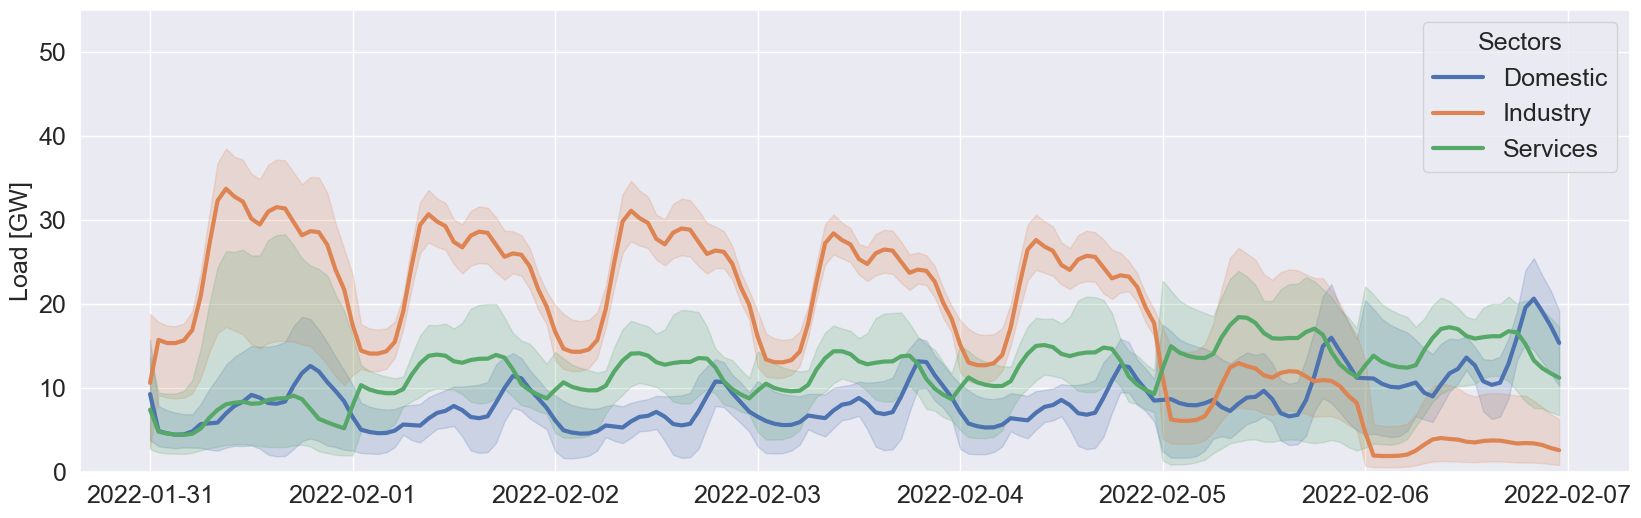

In [11]:
period = ["2022-01-31 00:00:00", "2022-02-06 23:59:00"]
plot_decomposed_load(decomposed_load, period, time_column='datetime', y_label="Load [GW]", ylim=(0, 55))

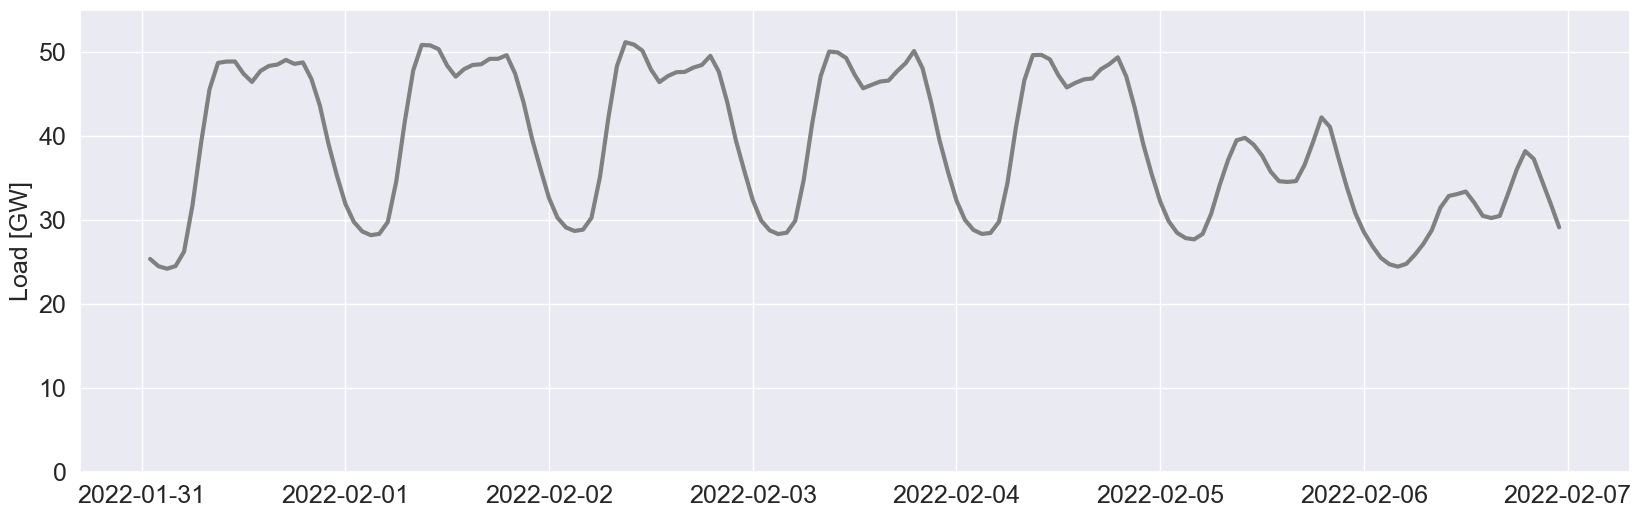

In [12]:
plot_aggregated_load(decomposed_load, period, time_column='datetime', y_label="Load [GW]", ylim=(0, 55))

In [13]:
day_df = decompose_daily_consumption(C_ens, E)
day_df['Domestic'] = day_df['$S_1$'] + day_df['$S_2$']
day_df['Industry'] = day_df['$S_3$']
day_df['Services'] = day_df['$S_4$'] + day_df['$S_5$']
day_df.drop(columns=[f'$S_{k+1}$' for k in range(K)], inplace=True)
day_df['date'] = day_df['date'].astype('datetime64[ns]')
day_df

,model,date,zone,Domestic,Industry,Services
0,0,2020-01-01,Italy,266.004876,5.213789,321.443855
1,1,2020-01-01,Italy,285.570753,4.557847,302.581563
2,2,2020-01-01,Italy,268.182747,11.998974,312.256331
3,3,2020-01-01,Italy,298.598481,21.116161,272.657730
4,4,2020-01-01,Italy,249.691409,7.331457,335.567863
...,...,...,...,...,...,...
574168,388,2023-12-31,Italy,274.984698,74.596367,253.424668
574169,389,2023-12-31,Italy,283.123395,55.791559,264.096205
574170,390,2023-12-31,Italy,249.435248,17.722277,336.173295
574171,391,2023-12-31,Italy,266.102990,51.175625,285.771142


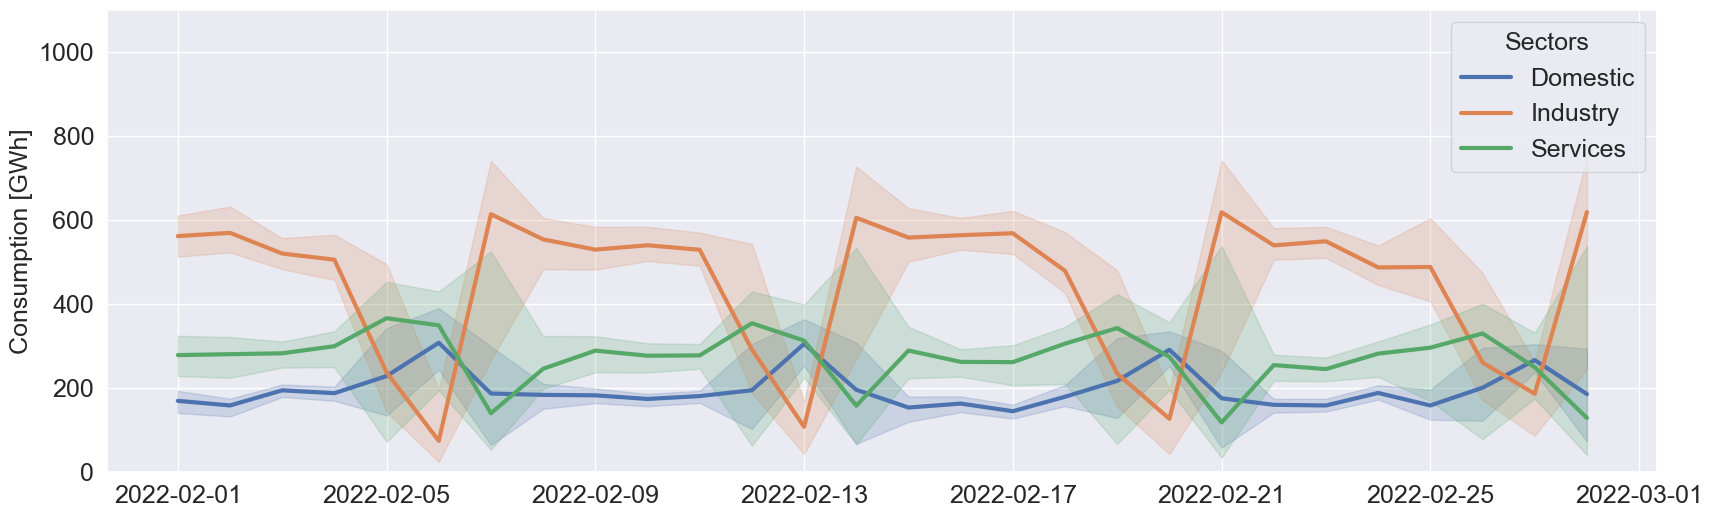

In [14]:
period = ["2022-02-01", "2022-02-28"]
plot_decomposed_load(day_df, period, time_column='date', y_label="Consumption [GWh]", ylim=(0, 1100))

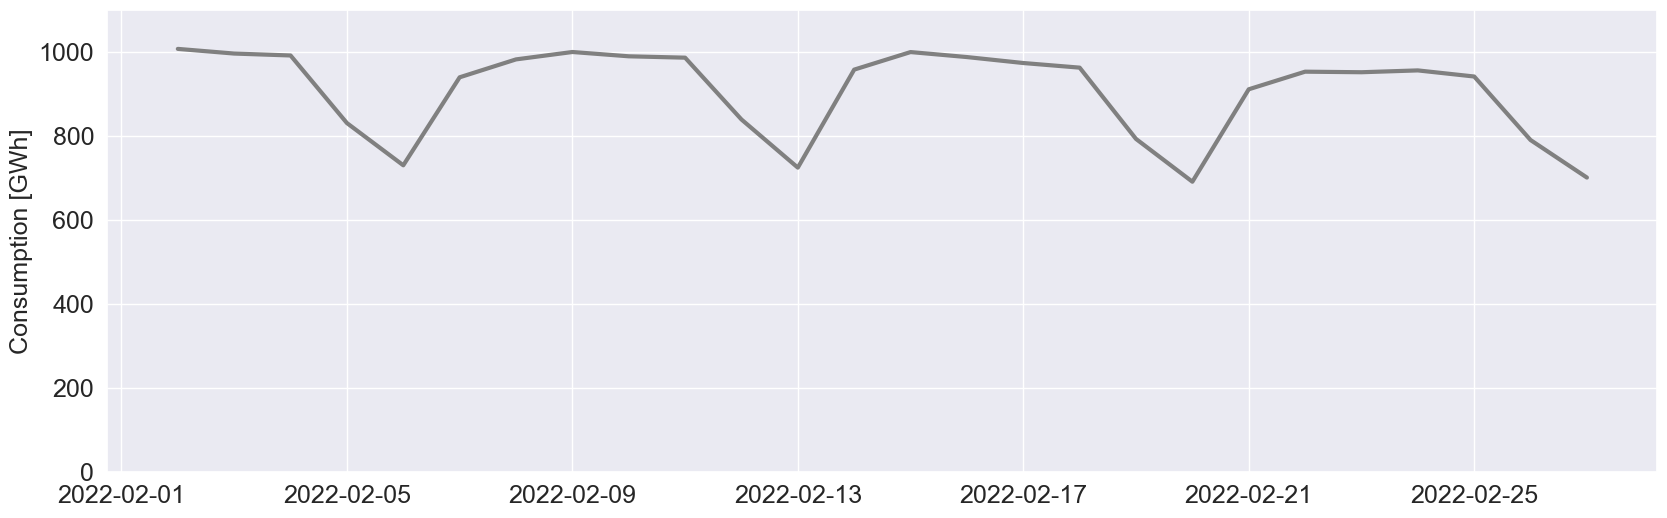

In [15]:
plot_aggregated_load(day_df, period, time_column='date', y_label="Consumption [GWh]", ylim=(0, 1100))

In [16]:
day_df['month'] = pd.to_datetime(day_df['date']).dt.to_period('M')

month_df = day_df.groupby(['month', 'zone', 'model'], as_index=False, sort=False)[sectors].sum()
month_df['year'] = month_df.month.dt.year
month_df

,month,zone,model,Domestic,Industry,Services,year
0,2020-01,Italy,0,6726.070851,12056.762221,8644.790505,2020
1,2020-01,Italy,1,6727.812997,12085.658166,8617.815971,2020
2,2020-01,Italy,2,6714.736456,12058.460089,8652.139535,2020
3,2020-01,Italy,3,6670.166628,12085.113904,8673.329628,2020
4,2020-01,Italy,4,6716.849205,12050.585203,8660.755315,2020
...,...,...,...,...,...,...,...
18859,2023-12,Italy,388,5984.046301,10642.001748,8186.378676,2023
18860,2023-12,Italy,389,6037.512838,10630.953385,8143.077730,2023
18861,2023-12,Italy,390,5951.530286,10652.426463,8205.839980,2023
18862,2023-12,Italy,391,6002.072642,10506.900616,8302.098476,2023


In [17]:
year_df = month_df.groupby(['zone', 'year', 'model'], as_index=False)[sectors].sum()
year_df

,zone,year,model,Domestic,Industry,Services
0,Italy,2020,0,71380.662622,138945.899265,91254.285148
1,Italy,2020,1,71438.612993,138847.976377,91296.686910
2,Italy,2020,2,71495.323390,139105.719855,90980.219051
3,Italy,2020,3,71580.801349,139163.795675,90843.055978
4,Italy,2020,4,71309.602780,138952.617202,91319.311380
...,...,...,...,...,...,...
1567,Italy,2023,388,62434.935671,142407.365274,101346.809308
1568,Italy,2023,389,63148.313660,143166.112239,99865.525558
1569,Italy,2023,390,60708.236734,152015.665333,93407.528711
1570,Italy,2023,391,62419.600052,144836.724947,98912.255048


## Test the monthly consumption decomposition with ASC and MSI

In [18]:
year_totals = unit_info.groupby('year')['cons'].sum()
year_month_totals = unit_info.groupby(['year', 'month'])['cons'].sum()

cons_df = process_sector_consumption(consumption_file, year_totals)
indics_df = get_indicators(imser_file, imcei_file, enel_files)
Y = get_Y(indics_df, cons_df, year_month_totals)
Y.head()

,Domestic,Industry,Services
Mese,,,
2020-01-01,6578.069013,12076.214575,8758.839428
2020-02-01,5527.985114,12490.529300,7644.235592
2020-03-01,6397.951558,10704.954781,6622.130700
2020-04-01,5700.031442,8660.806370,5383.390680
2020-05-01,4977.937414,11658.651789,6011.084788


In [19]:
Y_pred = month_df.copy()
Y_pred = Y_pred.groupby(['year', 'month', 'model'], as_index=False).sum().drop('zone', axis=1)
Y_pred['date'] = Y_pred.month.dt.to_timestamp()
Y_pred.drop(columns=['year', 'month'], inplace=True)
# Set the 'date' column as the index
Y_pred.set_index('date', inplace=True)
Y_pred

,model,Domestic,Industry,Services
date,,,,
2020-01-01,0,6726.070851,12056.762221,8644.790505
2020-01-01,1,6727.812997,12085.658166,8617.815971
2020-01-01,2,6714.736456,12058.460089,8652.139535
2020-01-01,3,6670.166628,12085.113904,8673.329628
2020-01-01,4,6716.849205,12050.585203,8660.755315
...,...,...,...,...
2023-12-01,388,5984.046301,10642.001748,8186.378676
2023-12-01,389,6037.512838,10630.953385,8143.077730
2023-12-01,390,5951.530286,10652.426463,8205.839980


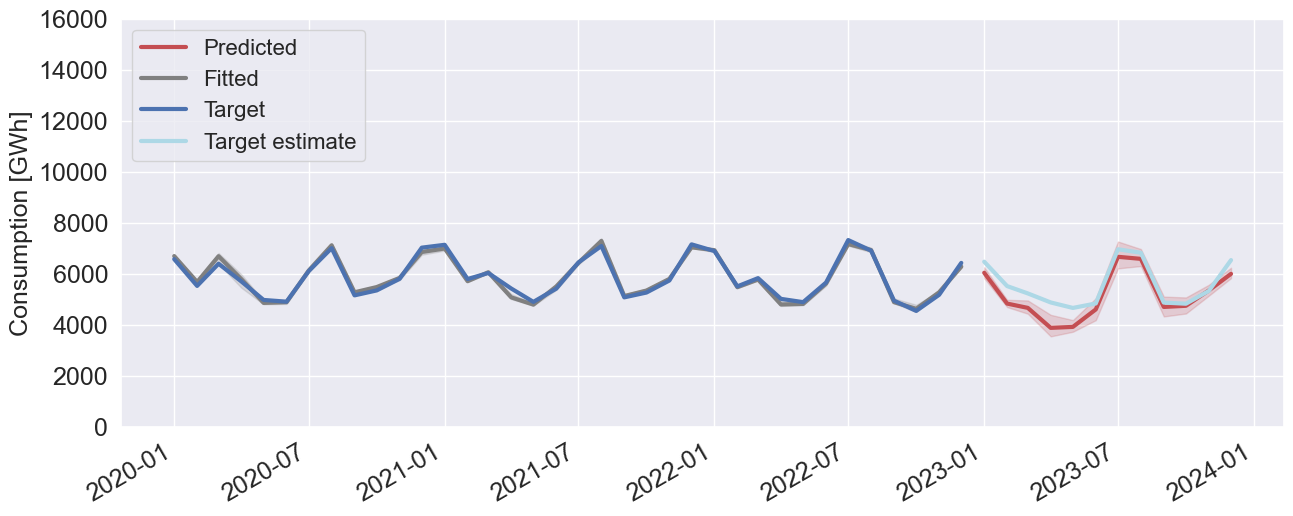

In [20]:
plot_monthly_cons(Y_pred, Y, "Domestic", train_months, test_months, linewidth=3, figsize=(15, 6), ylim=(0, 16000), fontsize=18)

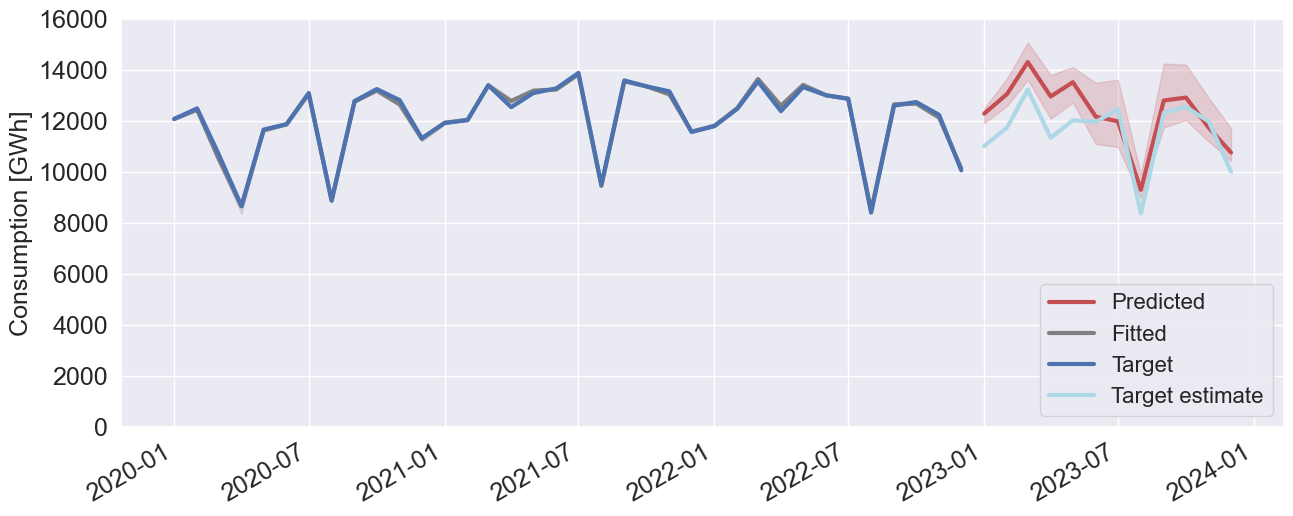

In [21]:
plot_monthly_cons(Y_pred, Y, "Industry", train_months, test_months, legend_loc='lower right')

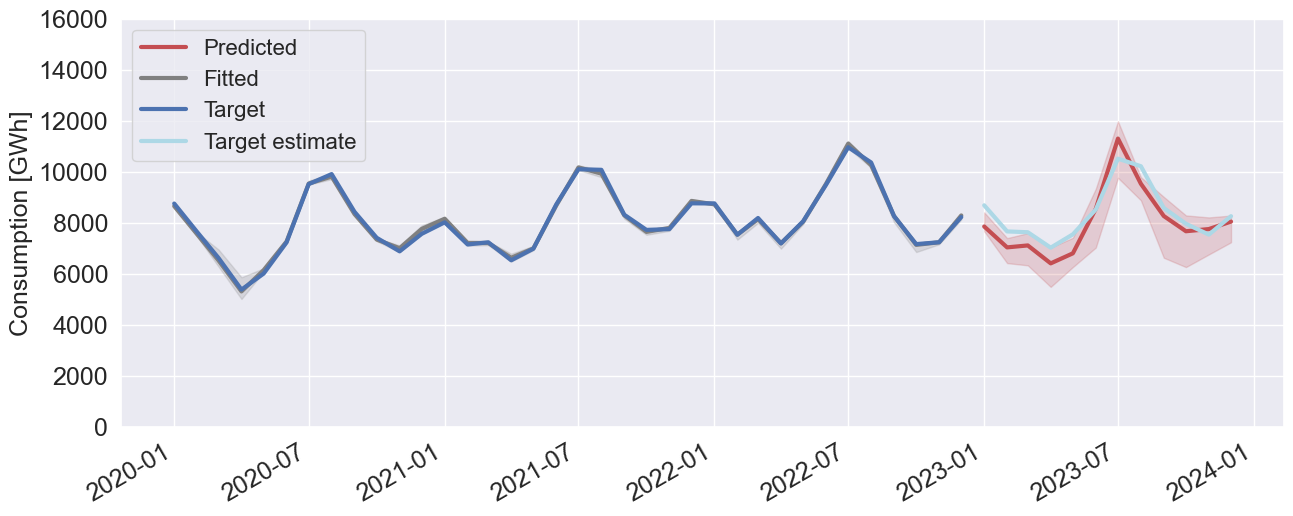

In [22]:
plot_monthly_cons(Y_pred, Y, "Services", train_months, test_months)

Test if the %YoY variations in the test set are consistent with those of the indicators, to show that we just don't catch some simple seaonality

In [23]:
Y_hat = Y_pred.groupby(Y_pred.index)[sectors].mean()
Y_hat.head()

,Domestic,Industry,Services
date,,,
2020-01-01,6698.893863,12072.205389,8655.768509
2020-02-01,5681.240656,12434.392266,7553.358419
2020-03-01,6693.594029,10520.317415,6524.024972
2020-04-01,5792.097260,8649.234528,5311.911888
2020-05-01,4862.051504,11635.499308,6146.529249


In [24]:
yoy_pred = Y_hat.pct_change(periods=12) * 100
yoy_pred_test = yoy_pred[yoy_pred.index.isin(test_months)]
yoy_pred_test

,Domestic,Industry,Services
date,,,
2023-01-01,-12.766374,4.036294,-9.947494
2023-02-01,-11.725383,4.402590,-6.593414
2023-03-01,-19.223393,4.873268,-12.671299
2023-04-01,-19.102305,2.884506,-10.922016
2023-05-01,-18.707766,0.786089,-15.384419
2023-06-01,-18.012906,-6.467079,-10.303732
2023-07-01,-6.955928,-6.896322,1.776543
2023-08-01,-4.973035,9.607949,-7.088463
2023-09-01,-3.816222,1.223752,0.023105


In [25]:
yoy_true = indics_df.pct_change(periods=12) * 100
yoy_true_test = yoy_true[yoy_true.index.isin(test_months)]
yoy_true_test

,IMCEI,IMSER,Enel
Mese,,,
2023-01-01,-8.473890,-2.871173,-8.698748
2023-02-01,-6.788000,0.713866,-1.582046
2023-03-01,-0.914706,-5.502422,-9.751816
2023-04-01,-9.089134,-3.063768,-4.350145
2023-05-01,-8.125113,-4.675995,-3.734658
2023-06-01,-5.778922,-8.022716,-13.110019
2023-07-01,-1.192687,-2.249073,-3.903441
2023-08-01,0.018503,-1.072174,-1.653867
2023-09-01,-0.939247,5.188813,-1.067821


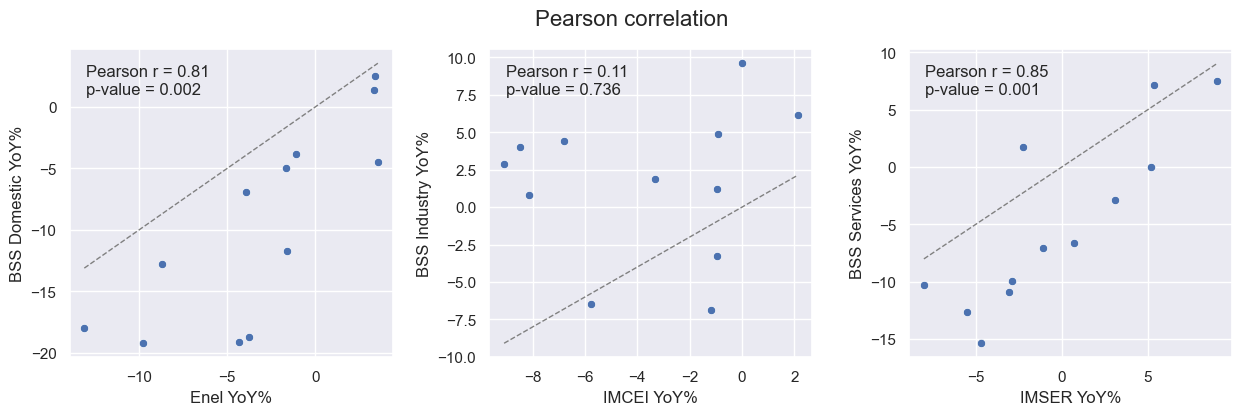

In [26]:
plot_correlation_yoy(yoy_true_test, yoy_pred_test, correlation='Pearson')

## Analyse sector load profiles

In [27]:
# Normalise the decomposed load to easily retrieve the profiles
D = get_D(p)
norms = decomposed_load.reset_index().groupby(['obs', 'model'], as_index=False, sort=False)[sectors].agg(lambda a: a.dot(D.squeeze()))
profiles = decomposed_load.copy()
profiles[sectors] = profiles[sectors] /  np.repeat(norms[sectors], repeats=p, axis=0)
profiles[unit_info.columns] = np.repeat(unit_info, repeats=p*N, axis=0)
profiles

,model,hour,obs,datetime,zone,Domestic,Industry,Services,date,region,year,month,daytype,cons,season
0,0,0.0,Italy_2020-01-01_Holiday,2020-01-01 00:00:00,Italy,0.029711,0.027531,0.050973,2020-01-01,Italy,2020,01,Holiday,592.946498,Winter
1,0,1.0,Italy_2020-01-01_Holiday,2020-01-01 01:00:00,Italy,0.026652,0.025833,0.047587,2020-01-01,Italy,2020,01,Holiday,592.946498,Winter
2,0,2.0,Italy_2020-01-01_Holiday,2020-01-01 02:00:00,Italy,0.025222,0.025205,0.044963,2020-01-01,Italy,2020,01,Holiday,592.946498,Winter
3,0,3.0,Italy_2020-01-01_Holiday,2020-01-01 03:00:00,Italy,0.024370,0.025151,0.043443,2020-01-01,Italy,2020,01,Holiday,592.946498,Winter
4,0,4.0,Italy_2020-01-01_Holiday,2020-01-01 04:00:00,Italy,0.024532,0.025604,0.042248,2020-01-01,Italy,2020,01,Holiday,592.946498,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14354320,392,20.0,Italy_2023-12-31_Holiday,2023-12-31 20:00:00,Italy,0.070722,0.045381,0.027171,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall
14354321,392,21.0,Italy_2023-12-31_Holiday,2023-12-31 21:00:00,Italy,0.057665,0.042707,0.034779,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall
14354322,392,22.0,Italy_2023-12-31_Holiday,2023-12-31 22:00:00,Italy,0.048073,0.038022,0.039067,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall
14354323,392,23.0,Italy_2023-12-31_Holiday,2023-12-31 23:00:00,Italy,0.040083,0.034396,0.040198,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall


In [28]:
profiles_ens = profiles.groupby(unit_info.columns.to_list() + ['model', 'hour'], as_index=False, sort=False)[sectors].mean()
profiles_ens

,region,year,month,daytype,cons,season,model,hour,Domestic,Industry,Services
0,Italy,2020,01,Holiday,592.946498,Winter,0,0.0,0.029711,0.027531,0.050973
1,Italy,2020,01,Holiday,592.946498,Winter,0,1.0,0.026652,0.025833,0.047587
2,Italy,2020,01,Holiday,592.946498,Winter,0,2.0,0.025222,0.025205,0.044963
3,Italy,2020,01,Holiday,592.946498,Winter,0,3.0,0.024370,0.025151,0.043443
4,Italy,2020,01,Holiday,592.946498,Winter,0,4.0,0.024532,0.025604,0.042248
...,...,...,...,...,...,...,...,...,...,...,...
14354320,Italy,2023,12,Holiday,602.807502,Fall,392,20.0,0.070722,0.045381,0.027171
14354321,Italy,2023,12,Holiday,602.807502,Fall,392,21.0,0.057665,0.042707,0.034779
14354322,Italy,2023,12,Holiday,602.807502,Fall,392,22.0,0.048073,0.038022,0.039067
14354323,Italy,2023,12,Holiday,602.807502,Fall,392,23.0,0.040083,0.034396,0.040198


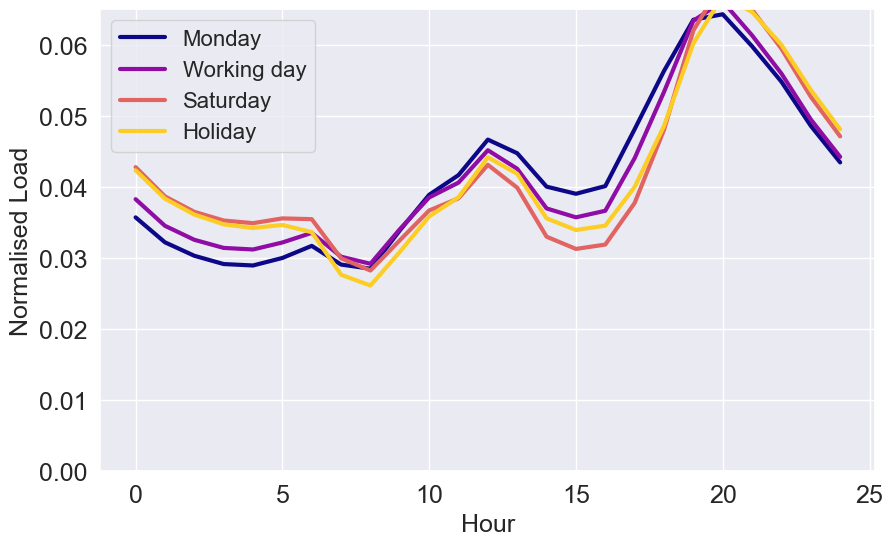

In [30]:
sector = 'Domestic'
hue = 'daytype'

palette = {
    'season': ['#77dd77', '#ffdb58', '#FF8C00', '#4682B4'],
    'daytype': [plasma(value) for value in np.linspace(0, 0.9, 4)]
}

plot_profiles(profiles_ens, sector, hue, palette=palette[hue])

## Export results

In [35]:
Y_pred_test = Y_pred[Y_pred.index.isin(test_months)]
Y_hat_test = Y_hat[Y_hat.index.isin(test_months)]
Y_hat_test.to_csv('data/sector_monthly_cons_mean.csv')
Y_pred_test.to_csv('data/sector_monthly_cons_distrib.csv')

<HR>

# TESTS